# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
#!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from datasets import load_dataset 
from transformers import (
    Blip2VisionConfig,
    Blip2QFormerConfig,
    OPTConfig,
    Blip2Config,
    Blip2ForConditionalGeneration,
    #PhiConfig,
    Blip2Model,
    AutoModelForCausalLM
)
from transformers import AutoProcessor, AutoTokenizer
import bitsandbytes
from peft import LoraConfig, get_peft_model

/home/everdistant/miniconda3/envs/blip2cap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'image': Image(decode=True, id=None), 'text': Value(dtype='string', id=None)}

["Benzema after Real Mardid's win against PSG",
 'Maradona after winning the 1986 FIFA World Cup with Argentina',
 'Messi with Argentina at the 2022 FIFA World Cup',
 'Pirlo with Juventus in 2014',
 'Ronaldo with Portugal at the 2018 World Cup',
 'Zidane with France in 2006 World Cup']

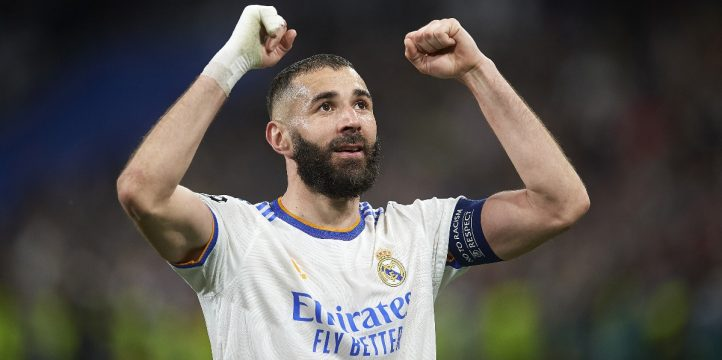

In [3]:
dataset = load_dataset("ybelkada/football-dataset", split="train")

display(dataset.features)
display(dataset['text'])
display(dataset[0]["image"])

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [4]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [5]:
base_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", 
    device_map="auto", load_in_8bit=True)
original_language_projection = base_model.language_projection
display(base_model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
            (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post

In [6]:
ORIGINAL_LANGUAGE_PROJECTION_WEIGHTS_FILE = '../models/original_language_projection.float32.pt'

#https://huggingface.co/blog/hf-bitsandbytes-integration#usage
# base_model_fp32 = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto")
# torch.save(base_model_fp32.language_projection.state_dict(), ORIGINAL_LANGUAGE_PROJECTION_WEIGHTS_FILE)

original_language_projection_fp32 = torch.load(ORIGINAL_LANGUAGE_PROJECTION_WEIGHTS_FILE)
print(original_language_projection_fp32['weight'])

tensor([[ 0.0350,  0.0224,  0.0200,  ...,  0.0130,  0.0083, -0.0129],
        [-0.0355, -0.0216,  0.0595,  ..., -0.0018, -0.0184,  0.0166],
        [-0.0355,  0.0030, -0.0226,  ...,  0.0212, -0.0010, -0.0012],
        ...,
        [ 0.0221,  0.0474, -0.0399,  ..., -0.0107,  0.0301, -0.0098],
        [ 0.0454,  0.0618, -0.0290,  ...,  0.0602,  0.0097,  0.0106],
        [ 0.0114, -0.0050, -0.0080,  ..., -0.0276,  0.0015,  0.0012]],
       device='cuda:0')


In [7]:
lp_weight = original_language_projection_fp32['weight'].cpu().numpy()

U,S,Vh = np.linalg.svd(lp_weight.T, full_matrices=False) # (U @ np.diag(S)) @ V
print("U,S,Vh: ", U.shape, S.shape, Vh.shape) #(768, 768) (768,) (768, 2560)
principal_components = U @ np.diag(S)
print("U * S = principal components: ", principal_components)
principal_components_layer_quantized = bitsandbytes.nn.Linear8bitLt(
    principal_components.shape[0], principal_components.shape[1])

language_reprojection = bitsandbytes.nn.Linear8bitLt(
    principal_components.shape[1], 2048)
language_reprojection.to(base_model.device)
print("Initialized language reprojection (quantized): ", language_reprojection.weight)

principal_components_layer_fp32 = nn.Linear(principal_components.shape[0],principal_components.shape[1])
with torch.no_grad():
    principal_components_layer_fp32.weight.copy_(torch.tensor(principal_components))
print("Initialized principal components layer weights (fp32): ", principal_components_layer_fp32.weight)

principal_components_layer_quantized.load_state_dict(principal_components_layer_fp32.state_dict())
principal_components_layer_quantized.to(base_model.device) #Performs the quantization. See https://huggingface.co/blog/hf-bitsandbytes-integration#usage 
print("Initialized principal components layer weights (quantized): ", principal_components_layer_quantized.weight)

U,S,Vh:  (768, 768) (768,) (768, 2560)
U * S = principal components:  [[-2.5967863e-01 -3.3935800e-02  1.4263862e-01 ...  1.7970737e-02
  -2.1915699e-03  9.3483943e-03]
 [ 1.9707309e-01 -5.5720016e-02  1.4629775e-01 ...  2.7146566e-04
  -2.5104977e-02  2.5493208e-02]
 [ 2.1368280e-02  3.2554016e-01  2.9239482e-01 ...  2.1951726e-02
  -9.9950759e-03  4.0448201e-03]
 ...
 [-2.6400626e-01 -9.8623550e-03  3.3537567e-01 ...  2.8267455e-05
   3.5889115e-02  1.4877150e-02]
 [-1.4176871e-01 -3.3147305e-01  1.4438045e-01 ...  2.6265234e-02
  -8.8664377e-03  1.5073439e-02]
 [-1.3806768e-01  2.0550339e-01  1.9288900e-01 ...  2.3406260e-02
  -4.3458629e-02  1.1732641e-02]]
Initialized language reprojection (quantized):  Parameter containing:
Parameter(Int8Params([[ 0.0097,  0.0254, -0.0298,  ..., -0.0138,  0.0141, -0.0106],
            [-0.0132,  0.0345,  0.0284,  ..., -0.0145, -0.0332,  0.0019],
            [-0.0142,  0.0227,  0.0111,  ..., -0.0277,  0.0279,  0.0223],
            ...,
           

In [8]:
base_model.language_projection = nn.Sequential(
    principal_components_layer_quantized, # "language_projection.0",
    #nn.ReLU(),
    language_reprojection #"language_projection.1"
)

In [9]:
opt_1_3_lm = AutoModelForCausalLM.from_pretrained('facebook/opt-1.3b',
    #torch_dtype=torch.float16,
    #torch_dtype=torch.bfloat16,
    trust_remote_code=False,
    #local_files_only=True
    device_map='auto',load_in_8bit=True

)
base_model.language_model = opt_1_3_lm
base_model.post_init()

display(base_model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
            (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post

In [10]:
model = get_peft_model(base_model, LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        #"q_proj", 
        # "k_proj",
        "language_projection.0",
        "language_projection.1"
    ],
))

model.print_trainable_parameters()
display(model.language_projection)
display(model.language_model)

trainable params: 69,632 || all params: 2,409,107,712 || trainable%: 0.002890364745966161


Sequential(
  (0): lora.Linear8bitLt(
    (base_layer): Linear8bitLt(in_features=768, out_features=768, bias=True)
    (lora_dropout): ModuleDict(
      (default): Dropout(p=0.05, inplace=False)
    )
    (lora_A): ModuleDict(
      (default): Linear(in_features=768, out_features=16, bias=False)
    )
    (lora_B): ModuleDict(
      (default): Linear(in_features=16, out_features=768, bias=False)
    )
    (lora_embedding_A): ParameterDict()
    (lora_embedding_B): ParameterDict()
  )
  (1): lora.Linear8bitLt(
    (base_layer): Linear8bitLt(in_features=768, out_features=2048, bias=True)
    (lora_dropout): ModuleDict(
      (default): Dropout(p=0.05, inplace=False)
    )
    (lora_A): ModuleDict(
      (default): Linear(in_features=768, out_features=16, bias=False)
    )
    (lora_B): ModuleDict(
      (default): Linear(in_features=16, out_features=2048, bias=False)
    )
    (lora_embedding_A): ParameterDict()
    (lora_embedding_B): ParameterDict()
  )
)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2048, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2048)
      (final_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
            (v_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
            (q_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
            (out_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear8bitLt(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear8bitLt(in_features=8192, out_features=2048, bias=True)


Target caption: Maradona after winning the 1986 FIFA World Cup with Argentina


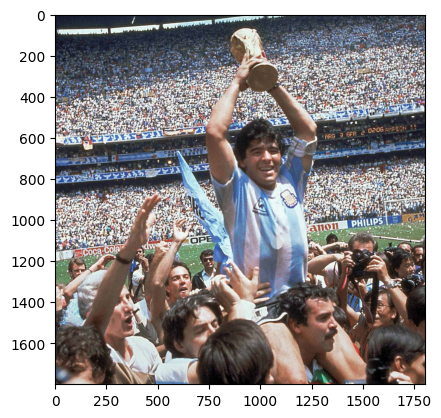

In [11]:
IDX = 1

example = dataset[IDX]
print(f"Target caption: {dataset['text'][IDX]}")
example_image = example["image"]
plt.imshow(example_image)

## Train the model

In [12]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Target caption: {dataset['text'][IDX]}")
example_inputs = processor(images=example_image, return_tensors="pt").to(device, torch.float16)
example_pixel_values = example_inputs.pixel_values

tokenizer = AutoTokenizer.from_pretrained('Salesforce/blip2-opt-2.7b')
example_generated_ids = model.generate(pixel_values=example_pixel_values, max_length=25)
example_generated_caption = tokenizer.batch_decode(example_generated_ids, skip_special_tokens=True)[0]
print(example_generated_caption)

for epoch in tqdm(range(150)):
  model.train()
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    model.eval()
    example_generated_ids = model.generate(pixel_values=example_pixel_values, max_length=25)
    example_generated_caption = tokenizer.batch_decode(example_generated_ids, skip_special_tokens=True)[0]
    print(f"Loss: {loss.item():.4f} Caption: {example_generated_caption}")

Target caption: Maradona after winning the 1986 FIFA World Cup with Argentina
I'm not sure if this is a good idea.             


  1%|          | 1/150 [00:02<07:19,  2.95s/it]

Loss: 7.4648 Caption: I'm not sure if this is a joke or not, but I'm pretty sure that's not how it works.


  1%|▏         | 2/150 [00:05<07:08,  2.90s/it]

Loss: 7.6875 Caption: I'm not sure if this is a good idea.             


  2%|▏         | 3/150 [00:08<07:02,  2.88s/it]

Loss: 5.5156 Caption: I'm not sure if this is a good idea.             


  3%|▎         | 4/150 [00:11<06:58,  2.87s/it]

Loss: 6.7344 Caption: I'm not sure if this is a good idea.             


  3%|▎         | 5/150 [00:14<06:53,  2.85s/it]

Loss: 5.4531 Caption: I'm not sure if this is a good idea.             


  4%|▍         | 6/150 [00:17<06:50,  2.85s/it]

Loss: 4.8984 Caption: I'm not sure if this is a good idea.             


  5%|▍         | 7/150 [00:20<06:47,  2.85s/it]

Loss: 6.3086 Caption: I'm not sure if this is a good idea.             


  5%|▌         | 8/150 [00:22<06:44,  2.85s/it]

Loss: 4.9922 Caption: I'm not sure if this is a good idea.  I mean, I'm not sure if it's a bad


  6%|▌         | 9/150 [00:25<06:42,  2.86s/it]

Loss: 4.9844 Caption: I'm not sure if this is a good idea.  I mean, I'm not sure if it's a bad


  7%|▋         | 10/150 [00:28<06:40,  2.86s/it]

Loss: 5.2969 Caption: I'm not sure if this is a good idea.             


  7%|▋         | 11/150 [00:31<06:37,  2.86s/it]

Loss: 4.2734 Caption: I'm not sure if this is a good idea.             


  8%|▊         | 12/150 [00:34<06:35,  2.87s/it]

Loss: 5.4180 Caption: I'm not sure if this is a good idea.  I mean, I'm not sure if it's a bad


  9%|▊         | 13/150 [00:37<06:32,  2.86s/it]

Loss: 5.2773 Caption: I'm not sure if this is a good idea.  I mean, I'm not sure if it's a bad


  9%|▉         | 14/150 [00:40<06:27,  2.85s/it]

Loss: 4.6875 Caption: I'm not sure if this is a good idea.             


 10%|█         | 15/150 [00:42<06:25,  2.86s/it]

Loss: 4.7188 Caption: I'm not sure if this is a good idea.             


 11%|█         | 16/150 [00:45<06:24,  2.87s/it]

Loss: 4.9062 Caption: I'm not sure if this is a good idea.             


 11%|█▏        | 17/150 [00:48<06:22,  2.87s/it]

Loss: 5.6094 Caption: I'm not sure if this is a good idea.             


 12%|█▏        | 18/150 [00:51<06:18,  2.87s/it]

Loss: 4.9414 Caption: I'm not sure if this is a good idea.             


 13%|█▎        | 19/150 [00:54<06:16,  2.87s/it]

Loss: 4.8789 Caption: I'm not sure if this is a good idea.             


 13%|█▎        | 20/150 [00:57<06:12,  2.86s/it]

Loss: 4.3281 Caption: I'm not sure if this is a good idea.             


 14%|█▍        | 21/150 [01:00<06:08,  2.86s/it]

Loss: 4.9414 Caption: I'm not sure if this is a good idea.             


 15%|█▍        | 22/150 [01:02<06:04,  2.85s/it]

Loss: 4.4805 Caption: I'm not sure if this is a good idea.             


 15%|█▌        | 23/150 [01:05<05:58,  2.82s/it]

Loss: 4.4766 Caption: I'm not sure if this is a good idea.             


 16%|█▌        | 24/150 [01:08<05:55,  2.82s/it]

Loss: 5.0938 Caption: I'm not sure if this is a good idea.             


 17%|█▋        | 25/150 [01:11<05:51,  2.81s/it]

Loss: 4.7031 Caption: I'm not sure if this is a good idea.  I mean, I'm not sure if it's a bad


 17%|█▋        | 26/150 [01:14<05:47,  2.80s/it]

Loss: 4.6875 Caption: I'm not sure if this is a good idea.             


 18%|█▊        | 27/150 [01:16<05:45,  2.81s/it]

Loss: 3.9688 Caption: I'm not sure if this is a good idea.             


 19%|█▊        | 28/150 [01:19<05:42,  2.81s/it]

Loss: 4.3906 Caption: I'm not sure if this is a good idea.             


 19%|█▉        | 29/150 [01:22<05:39,  2.81s/it]

Loss: 3.7695 Caption: I'm not sure if this is a good idea.             


 20%|██        | 30/150 [01:25<05:36,  2.80s/it]

Loss: 5.1680 Caption: I'm not sure if this is a good idea.             


 21%|██        | 31/150 [01:28<05:34,  2.81s/it]

Loss: 3.6152 Caption: I'm not sure if this is a good idea.             


 21%|██▏       | 32/150 [01:30<05:30,  2.80s/it]

Loss: 4.0781 Caption: I'm not sure if this is a good idea.             


 22%|██▏       | 33/150 [01:33<05:28,  2.80s/it]

Loss: 4.0703 Caption: I'm not sure if this is a good idea.             


 23%|██▎       | 34/150 [01:36<05:25,  2.81s/it]

Loss: 3.8535 Caption: I'm not sure if this is a good idea, but I think it would be cool to have a "best of


 23%|██▎       | 35/150 [01:39<05:22,  2.80s/it]

Loss: 4.9961 Caption: I'm not sure if this is a good idea, but I think it would be cool to have a "best of


 24%|██▍       | 36/150 [01:42<05:18,  2.80s/it]

Loss: 4.4805 Caption: I'm not sure if this is the right place to ask, but I'm looking for a good pair of running shoes


 25%|██▍       | 37/150 [01:44<05:15,  2.79s/it]

Loss: 3.7031 Caption: I'm not sure if this is the right place to ask, but I'm looking for a good pair of running shoes


 25%|██▌       | 38/150 [01:47<05:12,  2.79s/it]

Loss: 4.8125 Caption: I'm not sure if this is the right place to ask this, but I'm looking for a good place to buy


 26%|██▌       | 39/150 [01:50<05:09,  2.79s/it]

Loss: 3.3438 Caption: I'm not sure if this is the right place to ask this, but I'm looking for a good place to start


 27%|██▋       | 40/150 [01:53<05:06,  2.78s/it]

Loss: 3.9043 Caption: I'm not sure if this is the right place to ask this, but I'm looking for a good place to start


 27%|██▋       | 41/150 [01:55<05:02,  2.77s/it]

Loss: 4.4727 Caption: I'm not sure if this is the right place to ask this, but I'm looking for a good place to start


 28%|██▊       | 42/150 [01:58<04:58,  2.77s/it]

Loss: 4.3203 Caption: The first time I saw this movie, I was so amazed by the story, I was so amazed by the story,


 29%|██▊       | 43/150 [02:01<04:56,  2.77s/it]

Loss: 3.5488 Caption: The first time I saw this movie, I was so confused. I thought it was a movie about a guy who was


 29%|██▉       | 44/150 [02:04<04:54,  2.78s/it]

Loss: 3.9590 Caption: The first time I saw the movie, I was like "Oh, this is a good movie, I'll watch it


 30%|███       | 45/150 [02:07<04:51,  2.78s/it]

Loss: 3.6289 Caption: The first season of the X-Men was released in the United States on June 26, 2000.

The first


 31%|███       | 46/150 [02:09<04:50,  2.80s/it]

Loss: 3.7480 Caption: )

The first official match of the 2018 FIFA World Cup was between Argentina and Croatia on June 16, 2018,


 31%|███▏      | 47/150 [02:12<04:48,  2.80s/it]

Loss: 2.7676 Caption: Messi, Argentina, 2018 FIFA World Cup, Russia, 2018 FIFA World Cup, Russia, 2018 FIFA World Cup,


 32%|███▏      | 48/150 [02:15<04:45,  2.80s/it]

Loss: 3.3066 Caption: Messi, Argentina, 2018 FIFA World Cup, Russia, 2018 FIFA World Cup, Russia, 2018 FIFA World Cup,


 33%|███▎      | 49/150 [02:18<04:42,  2.79s/it]

Loss: 3.0508 Caption: Messi, Argentina, at the 2018 FIFA World Cup in Russia. (Photo by Clive Brunskill/Getty Images)


 33%|███▎      | 50/150 [02:21<04:38,  2.79s/it]

Loss: 2.4316 Caption: Messi with Argentina at the 2018 FIFA World Cup. (Photo by Clive Brunskill/Getty Images)

Mess


 34%|███▍      | 51/150 [02:23<04:34,  2.77s/it]

Loss: 2.0840 Caption: Messi's Barcelona future in doubt after Champions League exit
Messi's Barcelona future in doubt after Champions League exit



 35%|███▍      | 52/150 [02:26<04:31,  2.77s/it]

Loss: 2.8242 Caption: Messi's Barcelona future in doubt after Champions League exit
Messi's Barcelona future in doubt after Champions League exit



 35%|███▌      | 53/150 [02:29<04:27,  2.76s/it]

Loss: 2.6582 Caption: Messi with Argentina at the 2018 World Cup in Russia. (Photo by Clive Brunskill/Getty Images)




 36%|███▌      | 54/150 [02:32<04:24,  2.76s/it]

Loss: 2.3691 Caption: Messi with Argentina at the 2018 World Cup in Russia. (Photo by Matt Cardy/Getty Images)




 37%|███▋      | 55/150 [02:34<04:21,  2.75s/it]

Loss: 2.6738 Caption: Messi with Argentina at the 2018 World Cup. (AP Photo/Domenico Mancuso)




 37%|███▋      | 56/150 [02:37<04:17,  2.74s/it]

Loss: 2.2188 Caption: Messi with Argentina at the 2018 World Cup. (Photo by Clive Mason/Getty Images)

Messi has


 38%|███▊      | 57/150 [02:40<04:14,  2.74s/it]

Loss: 2.0156 Caption: Messi with Argentina at the 2018 World Cup. (Photo by Clive Mason/Getty Images)

Messi and


 39%|███▊      | 58/150 [02:42<04:11,  2.73s/it]

Loss: 1.6660 Caption: Messi's Barcelona future in doubt
Lionel Messi's future at Barcelona is in doubt after the club's humiliating


 39%|███▉      | 59/150 [02:45<04:09,  2.74s/it]

Loss: 2.2617 Caption: Messi with Argentina at the 2018 FIFA World Cup. (Photo by Clive Mason/Getty Images)

Messi


 40%|████      | 60/150 [02:48<04:06,  2.74s/it]

Loss: 1.5469 Caption: Messi with Argentina at the 2022 World Cup in Qatar. (Photo by Clive Mason/Getty Images)
Messi


 41%|████      | 61/150 [02:51<04:04,  2.75s/it]

Loss: 1.6738 Caption: Messi with Argentina at the 2022 World Cup in Qatar. (Photo by Clive Mason/Getty Images)
Messi


 41%|████▏     | 62/150 [02:54<04:02,  2.76s/it]

Loss: 2.0996 Caption: Messi with Argentina at the 2018 FIFA World Cup. (Photo by Clive Mason/Getty Images)

Messi


 42%|████▏     | 63/150 [02:56<03:59,  2.76s/it]

Loss: 1.7832 Caption: Messi's Barcelona future in doubt after Copa America win
Messi's Barcelona future in doubt after Copa America


 43%|████▎     | 64/150 [02:59<03:57,  2.76s/it]

Loss: 1.1484 Caption: Messi with Argentina at the 2018 FIFA World Cup in Russia. (Photo by Clive Mason/Getty Images)




 43%|████▎     | 65/150 [03:02<03:53,  2.75s/it]

Loss: 1.5059 Caption: Messi with Argentina at the 2018 World Cup in Russia. (Photo credit should read MATTEO ZANATTI


 44%|████▍     | 66/150 [03:05<03:51,  2.75s/it]

Loss: 1.5977 Caption: Messi with Argentina at the 2018 World CupMessi with Argentina at the 2018 World CupMessi with Argentina at the


 45%|████▍     | 67/150 [03:07<03:47,  2.74s/it]

Loss: 1.2842 Caption: Messi with Argentina at the 2018 World Cup. (Photo by Clive Mason/Getty Images)

Messi with


 45%|████▌     | 68/150 [03:10<03:42,  2.72s/it]

Loss: 1.7393 Caption: Messi's hat-trick against Argentina in the 2014 World Cup.

Messi's hat-trick


 46%|████▌     | 69/150 [03:13<03:39,  2.70s/it]

Loss: 1.4912 Caption: Messi's hat-trick against Argentina in the 2014 World Cup.

Messi's hat-trick


 47%|████▋     | 70/150 [03:15<03:37,  2.72s/it]

Loss: 0.9834 Caption: Messi's hat-trick against Argentina in the 2014 World Cup. (Getty Images)

Messi's


 47%|████▋     | 71/150 [03:18<03:36,  2.74s/it]

Loss: 1.6191 Caption: Maradona after winning the 1986 World Cup with Argentina. (Getty Images)

Maradona's career was


 48%|████▊     | 72/150 [03:21<03:34,  2.76s/it]

Loss: 1.2441 Caption: Maradona after winning the 1986 World Cup with Argentina. Photo: Getty Images.

Maradona with his


 49%|████▊     | 73/150 [03:24<03:33,  2.77s/it]

Loss: 1.3535 Caption: Ronaldo with Portugal at the 2018 World Cup in Russia. (All photos by Zidane's wife Cristiano Ronaldo


 49%|████▉     | 74/150 [03:27<03:30,  2.77s/it]

Loss: 1.1348 Caption: Pirlo with Juventus in 2014 FIFA World Cup Qualifiers against Brazil: "I think we could have done better.


 50%|█████     | 75/150 [03:29<03:27,  2.77s/it]

Loss: 1.4717 Caption: Ronaldo with Portugal at the 2018 World Cup. Photo: Getty Images.
Ronaldo with Portugal at the 2018 World


 51%|█████     | 76/150 [03:32<03:23,  2.75s/it]

Loss: 1.1650 Caption: Maradona with Argentina at the 1986 World Cup. Photo by Getty Images.

Maradona with Argentina at


 51%|█████▏    | 77/150 [03:35<03:21,  2.76s/it]

Loss: 1.1885 Caption: Messi scores in Argentina's win over Brazil in the 2014 World Cup. (Getty Images)

Messi scores


 52%|█████▏    | 78/150 [03:38<03:18,  2.76s/it]

Loss: 1.2324 Caption: Maradona with Argentina at the 1986 FIFA World Cup. Photo by Getty Images.

Maradona with Argentina


 53%|█████▎    | 79/150 [03:40<03:16,  2.77s/it]

Loss: 1.2588 Caption: Messi with Argentina at the 2022 World Cup.
Maradona with Argentina at the 2022 World Cup.
Mess


 53%|█████▎    | 80/150 [03:43<03:13,  2.77s/it]

Loss: 1.1230 Caption: Messi with Argentina at the 2022 FIFA World Cup.

Messi with Argentina at the 2022 FIFA World Cup.


 54%|█████▍    | 81/150 [03:46<03:11,  2.77s/it]

Loss: 0.7544 Caption: Ronaldo with Portugal at the 2014 FIFA World Cup. Photo by Clive Mardidou/FIFA.com.


 55%|█████▍    | 82/150 [03:49<03:09,  2.78s/it]

Loss: 1.4580 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina. (FIFA/FIFA World Cup 1986)



 55%|█████▌    | 83/150 [03:51<03:06,  2.78s/it]

Loss: 1.6006 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina. Maradona was the top scorer in the tournament with


 56%|█████▌    | 84/150 [03:54<03:03,  2.78s/it]

Loss: 1.2031 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona was awarded the FIFA World Player


 57%|█████▋    | 85/150 [03:57<03:00,  2.78s/it]

Loss: 1.3730 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico City. Maradona is wearing a shirt with


 57%|█████▋    | 86/150 [04:00<02:57,  2.78s/it]

Loss: 1.3770 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona is wearing a shirt with the


 58%|█████▊    | 87/150 [04:03<02:55,  2.78s/it]

Loss: 0.8657 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. (FIFA via Getty Images)
Mar


 59%|█████▊    | 88/150 [04:05<02:52,  2.78s/it]

Loss: 1.0908 Caption: Maradona with Argentina at the 1986 FIFA World Cup.

Maradona with Argentina at the 1986 FIFA World


 59%|█████▉    | 89/150 [04:08<02:49,  2.78s/it]

Loss: 0.8970 Caption: Messi with Argentina at the 2018 World Cup. (Photo by Clive Mardid/Getty Images)
Messi


 60%|██████    | 90/150 [04:11<02:47,  2.78s/it]

Loss: 1.0127 Caption: Messi with Argentina at the 2018 World Cup. (Fernando Tardelli/FIFA via Getty Images)


 61%|██████    | 91/150 [04:14<02:44,  2.79s/it]

Loss: 1.2549 Caption: Messi with Argentina at the 2018 World Cup=~=~=~=~


 61%|██████▏   | 92/150 [04:17<02:42,  2.80s/it]

Loss: 1.2139 Caption: Messi with Argentina at the 2022 World Cup=~=~=~=~=~=~=~=~


 62%|██████▏   | 93/150 [04:19<02:39,  2.80s/it]

Loss: 0.8989 Caption: Messi with Argentina at the 2022 FIFA World Cup=~=~


 63%|██████▎   | 94/150 [04:22<02:38,  2.82s/it]

Loss: 0.7153 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 63%|██████▎   | 95/150 [04:25<02:34,  2.81s/it]

Loss: 0.8472 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 64%|██████▍   | 96/150 [04:28<02:31,  2.81s/it]

Loss: 0.8433 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 65%|██████▍   | 97/150 [04:31<02:28,  2.80s/it]

Loss: 0.9907 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona scored the winning goal in the


 65%|██████▌   | 98/150 [04:33<02:24,  2.77s/it]

Loss: 0.9258 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 66%|██████▌   | 99/150 [04:36<02:21,  2.77s/it]

Loss: 0.9233 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona is to the right of the


 67%|██████▋   | 100/150 [04:39<02:19,  2.78s/it]

Loss: 1.0557 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona is wearing a shirt that says


 67%|██████▋   | 101/150 [04:42<02:16,  2.78s/it]

Loss: 0.9971 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona is wearing a shirt with the


 68%|██████▊   | 102/150 [04:44<02:13,  2.78s/it]

Loss: 0.8022 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina. Maradona is wearing a number 10 shirt.



 69%|██████▊   | 103/150 [04:47<02:10,  2.78s/it]

Loss: 0.5894 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina. Maradona is wearing a shirt with the number 10


 69%|██████▉   | 104/150 [04:50<02:07,  2.78s/it]

Loss: 0.7373 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona is wearing a shirt with the


 70%|███████   | 105/150 [04:53<02:05,  2.78s/it]

Loss: 0.9165 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Mexico. Maradona is wearing a shirt with the


 71%|███████   | 106/150 [04:56<02:02,  2.78s/it]

Loss: 0.6050 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 71%|███████▏  | 107/150 [04:58<01:59,  2.79s/it]

Loss: 0.5693 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 72%|███████▏  | 108/150 [05:01<01:56,  2.78s/it]

Loss: 0.4185 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 73%|███████▎  | 109/150 [05:04<01:53,  2.78s/it]

Loss: 0.8682 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 73%|███████▎  | 110/150 [05:07<01:50,  2.77s/it]

Loss: 0.7119 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 74%|███████▍  | 111/150 [05:09<01:48,  2.77s/it]

Loss: 0.5293 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 75%|███████▍  | 112/150 [05:12<01:45,  2.78s/it]

Loss: 0.9014 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 75%|███████▌  | 113/150 [05:15<01:43,  2.79s/it]

Loss: 0.6743 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 76%|███████▌  | 114/150 [05:18<01:40,  2.79s/it]

Loss: 0.7065 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 77%|███████▋  | 115/150 [05:21<01:37,  2.78s/it]

Loss: 0.7212 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 77%|███████▋  | 116/150 [05:23<01:34,  2.78s/it]

Loss: 0.9756 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the FIFA World Cup in Moscow. Maradona scored


 78%|███████▊  | 117/150 [05:26<01:31,  2.78s/it]

Loss: 0.9541 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the FIFA World Cup in Moscow. Maradona scored


 79%|███████▊  | 118/150 [05:29<01:29,  2.79s/it]

Loss: 0.6460 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 79%|███████▉  | 119/150 [05:32<01:26,  2.79s/it]

Loss: 0.8867 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 80%|████████  | 120/150 [05:35<01:23,  2.79s/it]

Loss: 0.3948 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 81%|████████  | 121/150 [05:37<01:20,  2.79s/it]

Loss: 0.8711 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 81%|████████▏ | 122/150 [05:40<01:18,  2.79s/it]

Loss: 0.4629 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 82%|████████▏ | 123/150 [05:43<01:15,  2.78s/it]

Loss: 0.6445 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracás Stadium in Buenos Aires. Marad


 83%|████████▎ | 124/150 [05:46<01:12,  2.78s/it]

Loss: 0.6392 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 83%|████████▎ | 125/150 [05:48<01:09,  2.77s/it]

Loss: 0.6143 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 84%|████████▍ | 126/150 [05:51<01:07,  2.79s/it]

Loss: 0.8179 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 85%|████████▍ | 127/150 [05:54<01:04,  2.81s/it]

Loss: 0.9385 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 85%|████████▌ | 128/150 [05:57<01:01,  2.82s/it]

Loss: 0.4036 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 86%|████████▌ | 129/150 [06:00<00:59,  2.82s/it]

Loss: 0.8452 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Moscow. Maradona is wearing a mask to protect


 87%|████████▋ | 130/150 [06:03<00:56,  2.82s/it]

Loss: 0.6904 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Moscow. Maradona is to the right. (


 87%|████████▋ | 131/150 [06:05<00:53,  2.82s/it]

Loss: 0.3911 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Moscow. Maradona is to the right. (


 88%|████████▊ | 132/150 [06:08<00:50,  2.82s/it]

Loss: 0.5854 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Moscow. Maradona is to the right. (


 89%|████████▊ | 133/150 [06:11<00:47,  2.82s/it]

Loss: 0.5845 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina in Moscow. Maradona is to the right. (


 89%|████████▉ | 134/150 [06:14<00:45,  2.84s/it]

Loss: 0.6118 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 90%|█████████ | 135/150 [06:17<00:42,  2.83s/it]

Loss: 0.5361 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracás Stadium in Buenos Aires. Marad


 91%|█████████ | 136/150 [06:20<00:40,  2.87s/it]

Loss: 0.5493 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Buenos Aires. Marad


 91%|█████████▏| 137/150 [06:23<00:37,  2.85s/it]

Loss: 0.7256 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 92%|█████████▏| 138/150 [06:25<00:34,  2.84s/it]

Loss: 0.2729 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracaro Stadium in Buenos Aires. Marad


 93%|█████████▎| 139/150 [06:28<00:31,  2.83s/it]

Loss: 0.4990 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Buenos Aires. Marad


 93%|█████████▎| 140/150 [06:31<00:28,  2.82s/it]

Loss: 0.6411 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracadona stadium in Buenos Aires. Mar


 94%|█████████▍| 141/150 [06:34<00:25,  2.82s/it]

Loss: 0.6934 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracás Stadium. Maradona is to


 95%|█████████▍| 142/150 [06:37<00:22,  2.80s/it]

Loss: 0.4348 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Buenos Aires. Marad


 95%|█████████▌| 143/150 [06:39<00:19,  2.77s/it]

Loss: 0.4229 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 96%|█████████▌| 144/150 [06:42<00:16,  2.76s/it]

Loss: 0.5034 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 97%|█████████▋| 145/150 [06:45<00:13,  2.74s/it]

Loss: 0.5713 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 97%|█████████▋| 146/150 [06:47<00:10,  2.72s/it]

Loss: 0.5562 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 98%|█████████▊| 147/150 [06:50<00:08,  2.70s/it]

Loss: 0.5518 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Rio de Janeiro. Mar


 99%|█████████▊| 148/150 [06:53<00:05,  2.70s/it]

Loss: 0.2737 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Buenos Aires. Marad


 99%|█████████▉| 149/150 [06:55<00:02,  2.70s/it]

Loss: 0.7095 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Buenos Aires. Marad


100%|██████████| 150/150 [06:58<00:00,  2.79s/it]

Loss: 0.5674 Caption: Maradona after winning the 1986 FIFA World Cup with Argentina at the Maracana stadium in Buenos Aires. Marad
